<a href="https://colab.research.google.com/github/danhall14/MSc-ML/blob/main/mimo_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MuJoCo Basics

## 1. Installation

In [1]:
!pip install mujoco

import os

# Set up GPU rendering.
# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

import mujoco

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 10.5 MB/s eta 0:00:00
Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Installing mediapy:
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.9 MB/s eta 0:00:00


## 2. Defining and loading a simple model

In [2]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
		<geom name="red_ball" mass=".5" type="sphere" size="0.05" rgba="1 0 0 1" pos="0 0 0.45"/>
    <geom name="green_cylinder" type="cylinder" size="0.05 0.2" rgba="0 1 0 1" pos="0 0 0.2"/>
  </worldbody>
</mujoco>
"""
# Make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

The `xml` string is written in MuJoCo's [MJCF](http://www.mujoco.org/book/modeling.html), which is an [XML](https://en.wikipedia.org/wiki/XML#Key_terminology)-based modeling language.
  - The only required element is `<mujoco>`. The smallest valid MJCF model is `<mujoco/>` which is a completely empty model.
  - All physical elements live inside the `<worldbody>` which is always the top-level body and constitutes the global origin in Cartesian coordinates.
  - We define two geom in the world named `red_ball` and `green_cylinder`.
  - The MJCF language is described in the documentation's [XML Reference chapter](https://mujoco.readthedocs.io/en/latest/XMLreference.html).

The `from_xml_string()` method invokes the model compiler, which creates a binary `mjModel` instance.

`mjData` contains the *state* and quantities that depend on it. The state is made up of time, [generalized](https://en.wikipedia.org/wiki/Generalized_coordinates) positions and generalized velocities. These are respectively `data.time`, `data.qpos` and `data.qvel`. In order to make a new `mjData`, all we need is our `mjModel`

## 3. Rendering

""

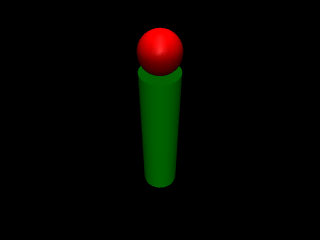

In [3]:
# Make renderer, render and show the pixels
with mujoco.Renderer(model) as renderer:

  # Compute the forward dynamics of the simulation
  # This updates positions, velocities, and other internal state in `data`
  mujoco.mj_forward(model, data)

  # Update the renderer’s scene to match the latest simulation state
  # Without this, the rendered image might show an old frame
  renderer.update_scene(data)

  # Render the current scene
  Image = renderer.render()

  # Display the rendered image
  media.show_image(Image)

## 4. Simulation

Now let's simulate and make a video. We'll use MuJoCo's main high level function `mj_step`, which steps the state $x_{t+h} = f(x_t)$.

In [4]:
def simulate_and_render(model, data, duration=3.8, framerate=60):
    # Initialize the frames list to store the video frames
    frames = []

    # Simulate and display video.
    mujoco.mj_resetData(model, data)  # Reset state and time.
    with mujoco.Renderer(model) as renderer:
      while data.time < duration:
        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate:
          renderer.update_scene(data)
          pixels = renderer.render()
          frames.append(pixels)

    media.show_video(frames, fps=framerate)
    return

simulate_and_render(model, data)

Hmmm, the video is playing, but nothing is moving, why is that?

This is because this model has no [degrees of freedom](https://www.google.com/url?sa=D&q=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FDegrees_of_freedom_(mechanics)) (DoFs). The things that move (and which have inertia) are called *bodies*. We add DoFs by adding *joints* to bodies, specifying how they can move with respect to their parents. Let's make a new body that contains our geoms, add a hinge joint and re-render, while visualizing the joint axis using the visualization option object `MjvOption`.

In [5]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-0.1 0 0"/>
		  <geom name="red_ball" mass=".5" type="sphere" size="0.05" rgba="1 0 0 1" pos="0 0 0.45"/>
      <geom name="green_cylinder" type="cylinder" size="0.05 0.2" rgba="0 1 0 1" pos="0 0 0.2"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

simulate_and_render(model, data)
print('Total number of DoFs in the model:', model.nv)
print('Generalized positions:', data.qpos)
print('Generalized velocities:', data.qvel)

Total number of DoFs in the model: 1
Generalized positions: [-5.55252641]
Generalized velocities: [1.7525444]


# MIMo


## 1. Installation



In [6]:
!git clone https://github.com/trieschlab/MIMo.git
import os
os.chdir('/content/MIMo')
!pip install -r requirements.txt
!pip install -e .

Cloning into 'MIMo'...
remote: Enumerating objects: 2914, done.
remote: Counting objects: 100% (584/584), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 2914 (delta 506), reused 411 (delta 411), pack-reused 2330 (from 3)
Receiving objects: 100% (2914/2914), 98.71 MiB | 22.71 MiB/s, done.
Resolving deltas: 100% (1694/1694), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 707.4/707.4 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 43.1 MB/s eta 0:00:00
   ━━━━━━

Obtaining file:///content/MIMo
  Preparing metadata (setup.py) ... done
  Running setup.py develop for MIMo


## 2. Import dependencies



In [7]:
import gymnasium as gym
import time
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import mimoEnv
from mimoEnv.envs.mimo_env import MIMoEnv
from mimoActuation.actuation import SpringDamperModel
from mimoActuation.muscle import MuscleModel
from stable_baselines3 import PPO as RL

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 3. Load and Control MIMo Model

In [8]:
os.chdir("/content/MIMo/mimoEnv/assets/")
xml = """
<mujoco>
	<include file="mimo/MIMo_meta.xml"></include>
  <worldbody>
    <light name="top" pos="0 0 1"/>
		<body name="mimo_location" pos="0 0 0.3" euler="0 0 0">
			<freejoint name="mimo_orientation"/>
			<include file="mimo/MIMo_model.xml"></include> <!-- Import the actual model-->
		</body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
# simulate_and_render(model, data)

""

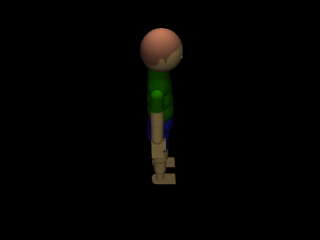

In [9]:
# Make renderer, render and show the pixels
with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  img_before = renderer.render()
media.show_image(img_before)

### Manually Set Joint Position


**List all joints in the model**

In [10]:
for i in range(model.njnt):  # model.njnt gives the number of joints
    joint_name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_JOINT, i)
    print(f"Joint {i}: {joint_name}")

Joint 0: mimo_orientation
Joint 1: robot:hip_lean1
Joint 2: robot:hip_rot1
Joint 3: robot:hip_bend1
Joint 4: robot:hip_lean2
Joint 5: robot:hip_rot2
Joint 6: robot:hip_bend2
Joint 7: robot:chest_lean
Joint 8: robot:chest_rot
Joint 9: robot:right_shoulder_horizontal
Joint 10: robot:right_shoulder_ad_ab
Joint 11: robot:right_shoulder_rotation
Joint 12: robot:right_elbow
Joint 13: robot:right_hand1
Joint 14: robot:right_hand2
Joint 15: robot:right_hand3
Joint 16: robot:right_fingers
Joint 17: robot:left_shoulder_horizontal
Joint 18: robot:left_shoulder_ad_ab
Joint 19: robot:left_shoulder_rotation
Joint 20: robot:left_elbow
Joint 21: robot:left_hand1
Joint 22: robot:left_hand2
Joint 23: robot:left_hand3
Joint 24: robot:left_fingers
Joint 25: robot:head_swivel
Joint 26: robot:head_tilt
Joint 27: robot:head_tilt_side
Joint 28: robot:left_eye_horizontal
Joint 29: robot:left_eye_vertical
Joint 30: robot:left_eye_torsional
Joint 31: robot:right_eye_horizontal
Joint 32: robot:right_eye_vertical


**Set the head tilt angle to 45 degrees**

In [11]:
head_tilt_name = "robot:head_tilt"  # Correct joint name (after checking the print output)
joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, head_tilt_name) # Get the joint ID
qpos_index = model.jnt_qposadr[joint_id]  # Get the qpos index for this joint
data.qpos[qpos_index] = np.deg2rad(45)  # Convert degrees to radians
mujoco.mj_step(model, data) # Step the simulation to apply changes

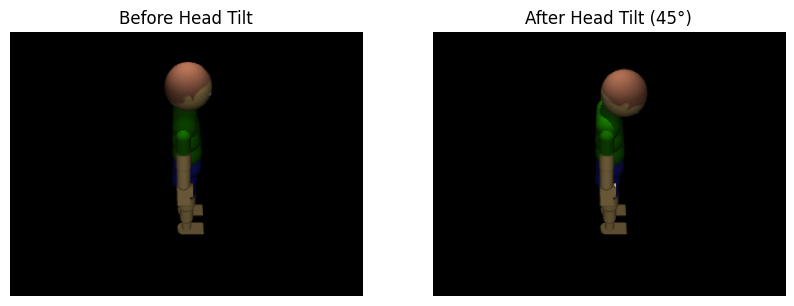

In [12]:
# Make renderer, render and show the pixels
with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  img_after = renderer.render()

# Plot side-by-side comparison
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_before)
ax[0].set_title("Before Head Tilt")
ax[0].axis("off")
ax[1].imshow(img_after)
ax[1].set_title("After Head Tilt (45°)")
ax[1].axis("off")
plt.show()

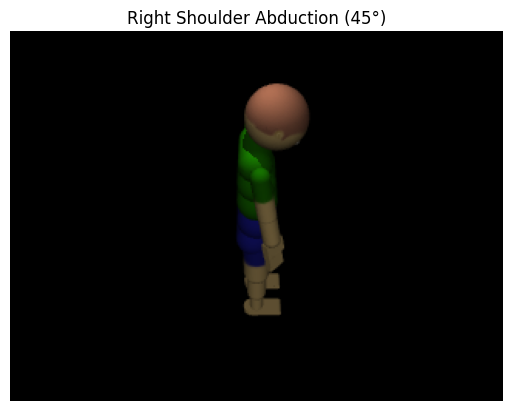

In [13]:
joint_name = "robot:right_shoulder_horizontal"  # Correct joint name (after checking the print output)
joint_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, joint_name) # Get the joint ID
qpos_index = model.jnt_qposadr[joint_id]  # Get the qpos index for this joint
data.qpos[qpos_index] = np.deg2rad(45)  # Convert degrees to radians
mujoco.mj_step(model, data) # Step the simulation to apply changes
# Render the updated model
with mujoco.Renderer(model) as renderer:
    mujoco.mj_forward(model, data)
    renderer.update_scene(data)
    img_after = renderer.render()

# Display the modified model
import matplotlib.pyplot as plt

plt.imshow(img_after)
plt.title("Right Shoulder Abduction (45°)")
plt.axis("off")
plt.show()

## 4. Load Environment

In [14]:
os.chdir('/content/MIMo')
env_name = 'catch'             #choices=['reach', 'standup', 'selfbody', 'catch']
actuation_model = SpringDamperModel

save_dir = os.path.join("models", env_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

env_names = {"reach": "MIMoReach-v0",
        "standup": "MIMoStandup-v0",
        "selfbody": "MIMoSelfBody-v0",
        "catch": "MIMoCatch-v0"}
env = gym.make(env_names[env_name], actuation_model=actuation_model, render_mode="rgb_array")
env.reset()

/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:787: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(


Action penalty:  True


({'observation': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -

In [15]:
model = env.unwrapped.model
data = env.unwrapped.data
simulate_and_render(model, data)

In [16]:
env.action_space

Box([-1.    -1.    -0.87  -1.    -0.345 -0.345 -0.345 -1.    -0.345 -0.345
 -0.345 -1.    -0.345 -0.345 -0.345 -1.    -0.345 -0.345 -0.345 -0.345], [1.   0.57 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.  ], (20,), float32)

In [17]:
env.action_space.sample()

array([-0.14804141, -0.6083534 ,  0.41015688,  0.3983111 , -0.02825369,
       -0.24015254,  0.02466829,  0.40881354, -0.295303  ,  0.8710997 ,
        0.11501334, -0.47515002,  0.7614284 ,  0.9379673 ,  0.7767956 ,
       -0.6453179 ,  0.37048563, -0.23968737,  0.5968068 ,  0.42946523],
      dtype=float32)

In [18]:
env.reset()

({'observation': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -

**Understanding the Environment**

The scene configuration for the `catch` action is defined in the files `catch_scene.xml` and `catch_meta.xml`, which are located in the `mimoEnv/assets/` directory.

In [19]:
# Find the actuator ID
actuator_name = "act:right_wrist_rotation"
actuator_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, actuator_name)

# Modify gear ratio
model.actuator_gear[actuator_id, 0] = -0.7

## 5. Train an RL model

Simple training and testing of RL algorithms in the demo environments.
  - A selection of RL algorithms from the Stable Baselines3 library can be selected.
  - Trained models are saved into the "/content/MIMo/mimoEnv/models/<scenario>" directory

In [20]:
model = RL("MultiInputPolicy", env, tensorboard_log=os.path.join("models", "tensorboard_logs", env_name), verbose=1)
train_for = 200000             # Total timesteps of training
save_every = 200000
# train model
counter = 0
while train_for > 0:
    counter += 1
    train_for_iter = min(train_for, save_every)
    train_for = train_for - train_for_iter
    model.learn(total_timesteps=train_for_iter, reset_num_timesteps=False)
    model.save(os.path.join(save_dir, "model_" + str(counter)))


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to models/tensorboard_logs/catch/PPO_0


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 42.1     |
|    ep_rew_mean     | -110     |
|    success_rate    | 0        |
| time/              |          |
|    fps             | 124      |
|    iterations      | 1        |
|    time_elapsed    | 16       |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 44.9          |
|    ep_rew_mean          | -106          |
|    success_rate         | 0.011         |
| time/                   |               |
|    fps                  | 117           |
|    iterations           | 2             |
|    time_elapsed         | 34            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.017653279   |
|    clip_fraction        | 0.19          |
|    clip_range           | 0.2           |
|    entro

**Understanding [Training Metrics](https://stable-baselines3.readthedocs.io/en/master/common/logger.html#explanation-of-logger-output) **


*  Evaluation Metrics: \
Ep_len_mean - Mean episode length. \
ep_rew_mean - Mean episodic training reward.
*  Time Metrics: \
Fps - Number of frames per seconds. \
iterations - Number of iterations (data collection + policy update for A2C/PPO). \
time_elapsed - Time in seconds since the beginning of training. \
total_timesteps - Total number of timesteps (steps in the environments).
*  Loss Metrics: \
Entropy_loss - Mean value of the entropy loss (negative of the average policy entropy). \
policy_gradient_loss - Current value of the policy gradient loss (its value does not have much meaning). \
value_loss - Current value for the value function loss for on-policy algorithms.
*  Other Metrics： \
Explained_variance - fraction of the return variance explained by the value function. \
Learning_rate - Current learning rate value. \
n_updates - Number of gradient updates applied so far.

## 6. Test Model

In [22]:
def test(env, save_dir, test_for=1000, model=None, render_video=False):
    """ Testing function to view the behaviour of a model.

    Args:
        env (MIMoEnv): The environment on which the model should be tested. This does not have to be the same training
            environment, but action and observation spaces must match.
        save_dir (str): The directory in which any rendered videos will be saved.
        test_for (int): The number of timesteps the testing runs in total. This will be broken into multiple episodes
            if necessary.
        model:  The stable baselines model object. If ``None`` we take random actions instead. Default ``None``.
        render_video (bool): If ``True``, all episodes during testing will be recorded and saved as videos in
            `save_dir`.
    """
    obs, _ = env.reset()
    images = []
    im_counter = 0

    for idx in range(test_for):
        if model is None:
            print("No model, taking random actions")
            action = env.action_space.sample()
        else:
            action, _ = model.predict(obs)
        obs, _, done, trunc, _ = env.step(action)
        if render_video:
            img = env.mujoco_renderer.render(render_mode="rgb_array")
            images.append(img)
        if done or trunc:
            time.sleep(1)
            obs, _ = env.reset()
            if render_video:
                fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                video = cv2.VideoWriter(os.path.join(save_dir, 'episode_{}.avi'.format(im_counter)), fourcc, 50, (500, 500))
                for img in images:
                    video.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
                # cv2.destroyAllWindows()
                video.release()

                images = []
                im_counter += 1

    env.reset()

test(env, save_dir, model=model, test_for=100, render_video=True)

Rendered test example videos are stored in the `model/catch` directory.

In [23]:
def test(env, test_for, model=None):
    obs, _ = env.reset()
    images = []
    im_counter = 0

    for idx in range(test_for):
      if model is None:
          print("No model, taking random actions")
          action = env.action_space.sample()
      else:
          action, _ = model.predict(obs)
      obs, _, done, trunc, _ = env.step(action)
      img = env.mujoco_renderer.render(render_mode="rgb_array")
      images.append(img)

      if done or trunc:
          env.reset()
          break  # End episode
    media.show_video(images, fps=60)

test(env, model=model, test_for=100)

## Practices
1. Using an alternative [RL algorithm](https://stable-baselines3.readthedocs.io/en/master/guide/algos.html)
2. [Try other tasks](https://github.com/trieschlab/MIMo)

* **reach** - A stripped down version where MIMo is tasked with reaching for a ball hovering in front of him. By default, only the proprioceptive sensors are used. MIMo can only move his right arm and his head is manually fixed to track the ball. The initial position of both the ball and MIMo is slightly randomized.

* **standup** - MIMo is tasked with standing up. At the start he is in a low crouch with his hands gripping the bars of a crib. Proprioception and the vestibular sensors are included by default.

* **selfbody** - MIMo is sitting on the ground and rewarded for touching a specific body part with his right arm. The target body part is randomized each episode.